## Libraries & Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def retrieve_sheets(path):
    
    dfs = pd.read_excel(path, parse_dates=True, sheet_name=None, index_col='Date')
    macro = dfs['Macro'].fillna(method='bfill').resample('Q').mean().round(2)
    prices = dfs['Prices'].fillna(method='bfill')
    yields = dfs['Yield']

    return macro, prices, yields


macro, prices, yields = retrieve_sheets('Data_010223.xlsx')

C:\Users\Ryan\AppData\Local\Temp\ipykernel_17852\446193735.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  macro = dfs['Macro'].fillna(method='bfill').resample('Q').mean().round(2)


<AxesSubplot: xlabel='Date'>

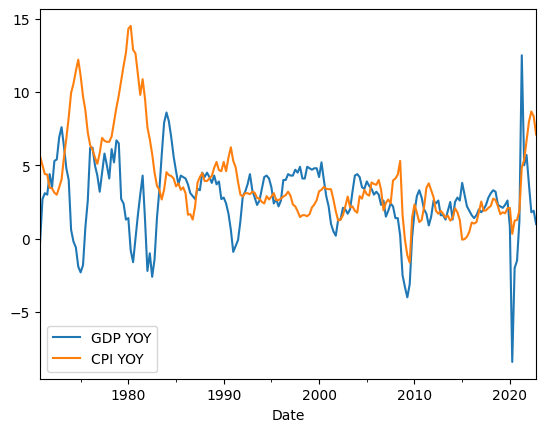

In [3]:
macro.plot()

# Data Prep

In [4]:
def create_returns(prices, yields):

    prices['SR'] = np.log(prices['S&P 500']) - np.log(prices['S&P 500'].shift(1))
    prices['GR'] = np.log(prices['Gold']) - np.log(prices['Gold'].shift(1))
    yields['YR'] = np.log(yields['US 10YR Bonds']) - np.log(yields['US 10YR Bonds'].shift(1))
    
    rets = pd.merge(prices, yields['YR'], left_index=True, right_index=True)[['SR', 'GR', 'YR']]
    return rets.resample('Q').sum()
    
df = create_returns(prices, yields)

# Regime

To determine regime, we want to determine if inflation and growth is rising or falling. We categorize an indicator as rising if it is greater than the previous quarter and falling if it is lesser than the previous quarters values.

0. Falling growth, falling inflation 
1. Falling growth, rising inflation  
2. Rising growth, falling inflation  
3. Rising growth, rising inflation 

In [5]:
def assign_regimes(df, macro):

    regimes = pd.DataFrame(index=macro.index)
    regimes['g'] = np.where(macro['GDP YOY'] > (macro['GDP YOY'].shift(1)), 1, 0)
    regimes['i'] = np.where(macro['CPI YOY'] > (macro['CPI YOY'].shift(1)), 1, 0)
    regimes['regime'] = (regimes.g.astype(str) + regimes.i.astype(str)).apply(lambda x: int(x,2))
    print(regimes.groupby('regime').count().g)
    return df.merge(regimes.regime,left_index=True, right_index=True,how='inner').dropna()

def split_rets(rets, date):
    train, test = rets[rets.index < date], rets[rets.index >= date]
    return train, test

In [6]:
rets = assign_regimes(df, macro)
train, test = split_rets(rets, '2012-01-01')

regime
0    54
1    62
2    54
3    39
Name: g, dtype: int64


# Signal

The strategy emits 4 fixed alphas (one for each regime) which when normalized so their absolute elements sum to unity $\sum_i |v_i=1|$ forms portfolio weights (long or short) to take in each regime.

The alpha vectors are naively created from normalizing the Sharpe ratio of the returns during each regime (for all time periods) on the training data. 

This is a simple method of creating an alpha that uses a summary statistic (Sharpe) of returns for each regime. However, the returns are not contiguous, because the regimes switch every quarter or so. An alternative method would be MVO, but will stick with the former.

The barchart shows the portfolio allocation in each regime.

In [7]:
def sharpe(return_series, n, rf, sortino=False):
    mean = (return_series.mean() * n) - rf
    if not sortino:
        sigma = return_series.std() * np.sqrt(n) 
    else:
        sigma = return_series[return_series<0].std() * np.sqrt(n)
    return mean/sigma

def create_weights(rets):
    alphas = rets.groupby('regime')[['SR','GR','YR']].apply(sharpe, n=4, rf=0.00) # this rf parameter is for alpha only, not evaluation.
    weights = alphas.div(abs(alphas).sum(axis=1), axis=0)
    return alphas, weights

In [8]:
alphas, weights = create_weights(train)

<AxesSubplot: xlabel='regime'>

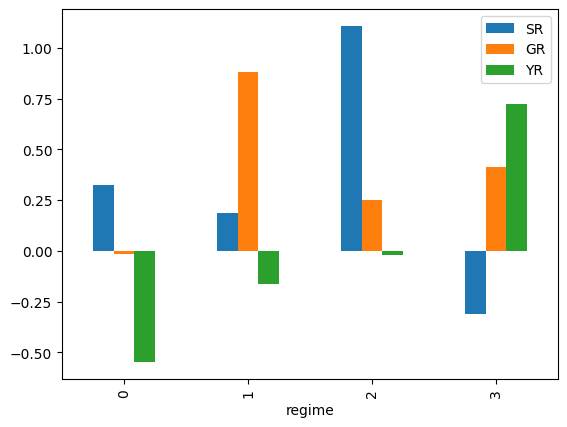

In [9]:
alphas.plot(kind='bar')

We can see that in regime 1 (high inflation, low growth), gold outperforms. In regime 3 (high growth, high inflation), the S&P underperforms.

# Performance

Once we compute the return series for our strategy, we can compare the performance to long S&P only. We assume there are no transaction costs incurred when rebalancing quarterly. Since the signal is fixed (4 alpha vectors), there is no quantile analysis or other diagnostics.

To evaluate performance, we can look at cumulative returns and IR given by $$I.R = \frac{E[R_p - R_b]}{\sqrt{var[R_p - R_b]}}$$ and Sharpe/Sortino.

In [10]:
def quarterly_rets(row, weights):
    regime_weights = weights.iloc[int(row[-1])]
    return regime_weights.dot(row[:-1])

def get_strat_rets(df):
    return df.apply(quarterly_rets, weights=weights, axis=1)

def construct_perf(df, benchmark):
    perf = pd.DataFrame({'strat': get_strat_rets(df), 'long_s&p': benchmark}, index=df.index)
    perf['tracking_error'] = perf.strat - perf['long_s&p']
    return perf

def ir(tracking_error, n):
    return (tracking_error.mean()*(n)/(tracking_error.std()* np.sqrt(n))).round(3)

In [11]:
train_perf = construct_perf(train, train.SR)
test_perf = construct_perf(test, test.SR)

In [12]:
print(f'Training period Information Ratio: {ir(train_perf.tracking_error, 4)}.')
print(f'Training period Sharpe: {sharpe(train_perf.strat, 4, 0.04).round(3)}.')
print(f'Training period Sortino: {sharpe(train_perf.strat, 4, 0.04, True).round(3)}.')
print('Training period long S&P Sharpe:', sharpe(train_perf['long_s&p'], 4, 0.02).round(3))
print('\n')
print(f'Testing period information ratio: {ir(test_perf.tracking_error, 4)}.')
print(f'Testing period Sharpe: {sharpe(test_perf.strat, 4, 0.04).round(3)}.')
print(f'Testign period Sortino: {sharpe(test_perf.strat, 4, 0.04, True).round(3)}.')
print('Testing period long S&P Sharpe:', sharpe(test_perf['long_s&p'], 4, 0.02).round(3))


Training period Information Ratio: 0.35.
Training period Sharpe: 0.629.
Training period Sortino: 1.276.
Training period long S&P Sharpe: 0.239


Testing period information ratio: 0.174.
Testing period Sharpe: 0.593.
Testign period Sortino: 1.057.
Testing period long S&P Sharpe: 0.532


Text(0.5, 1.0, 'Testing period cumulative return')

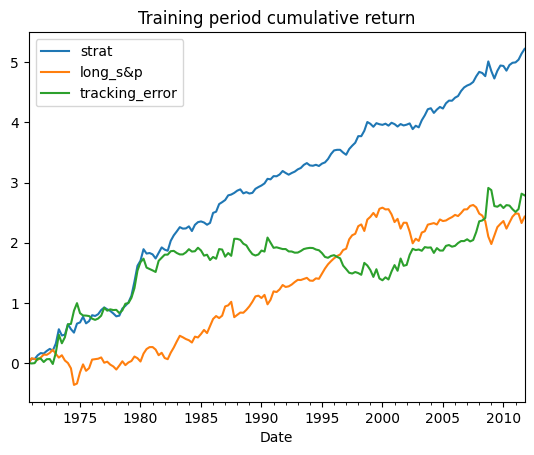

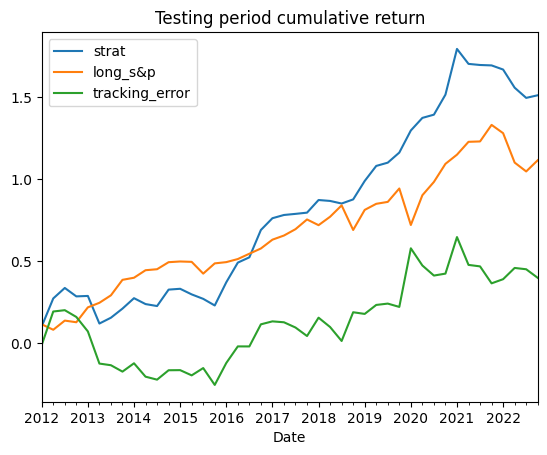

In [13]:

pd.options.plotting.backend = "matplotlib"
train_perf.cumsum().plot()
plt.title('Training period cumulative return')
test_perf.cumsum().plot()
plt.title('Testing period cumulative return')

Text(0.5, 1.0, 'Testing Period Tracking Error (+ve beats S&P)')

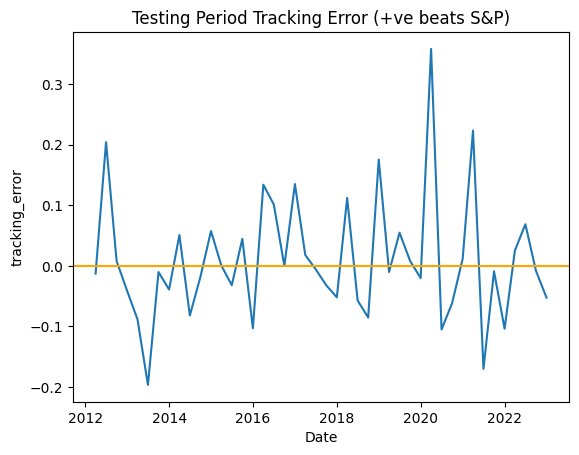

In [14]:
sns.lineplot(test_perf.tracking_error, markers=True)
plt.axhline(y=0, color='orange')
plt.title('Testing Period Tracking Error (+ve beats S&P)')

Text(0.5, 1.0, 'Testing Period 1Y rolling IR')

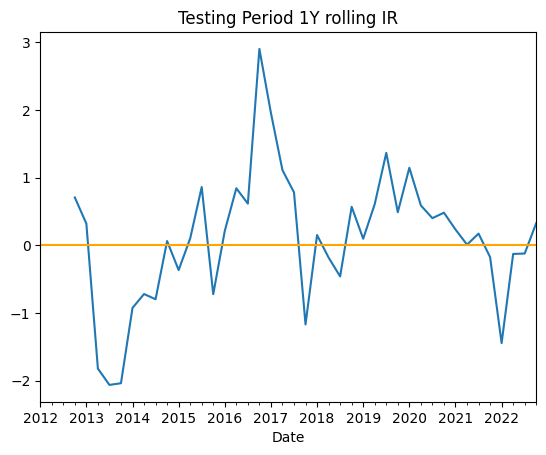

In [15]:
test_perf.tracking_error.rolling(window=4).apply(ir, raw=False, args=(4,)).plot()
plt.axhline(y=0, color='orange')
plt.title('Testing Period 1Y rolling IR')

Text(0.5, 1.0, 'Testing period 1Y rolling Sharpe')

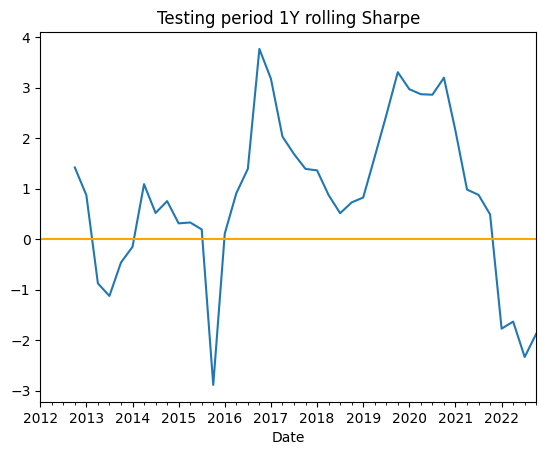

In [16]:
test_perf.strat.rolling(window=4).apply(sharpe, raw=False, args=(4,0.02)).plot()
plt.axhline(y=0, color='orange')
plt.title('Testing period 1Y rolling Sharpe')

# Evaluation

The strategy is naive and does not perform as well as desired, as a good information ratio is >0.5 compared to the in-sample IR of 0.3 and OOS IR of 0.18. However, it does beat long S&P as a benchmark.
Furthermore, t-costs were not taken into account. Also, lookahead bias might be incurred because we use the CPI/GDP YoY figures of the last month to form positions at the start of the next month.

## Improvements

We could consider making the weights market-neutral and evaluate performance by demeaning the standardized alpha vectors. 